#Hello World: The Teacup Model

This notebook demonstrates the basic capability of PySD using a model of a cup of tea cooling to room temperature.  

<img src="https://raw.githubusercontent.com/JamesPHoughton/pysd/master/example_models/Teacup/Teacup.png" alt="Image of Vensim Teacup Model" style="width: 300px;"/>

Our model simulates [Newton's Law of Cooling](http://www.ugrad.math.ubc.ca/coursedoc/math100/notes/diffeqs/cool.html), which follows the functional form:
$$\frac{dT}{dt} = k(T - T_{ambient})$$

This model has all of the canonical components of a system dynamics model: a stock, a flow, a feedback loop, a control parameter, and exhibits dynamic behavior. The model equations are:

    Characteristic Time=
            10
    Units: Minutes

    Heat Loss to Room=
        (Teacup Temperature - Room Temperature) / Characteristic Time
    Units: Degrees/Minute
    This is the rate at which heat flows from the cup into the room. 

    Room Temperature=
        70
    Units: Degrees

    Teacup Temperature= INTEG (
        -Heat Loss to Room,
            180)
    Units: Degrees
    
    
### Load the model
We begin by importing the PySD module using the python standard import commands. We then use PySD's Vensim model translator to import the model from the Vensim model file and create a model object. We see that PySD translates the vensim component names into acceptable python identifiers.

In [1]:
%pylab inline
import pysd
model = pysd.read_vensim('models/Teacup/Teacup.mdl')
print model.components.doc()

Populating the interactive namespace from numpy and matplotlib
characteristic_time = 10 
Type: Flow or Auxiliary 
 

This function returns an aggregation of all of the docstrings of all of the
elements in the model.

final_time = 30 
Type: Flow or Auxiliary 
 

heat_loss_to_room = (self.teacup_temperature()- self.room_temperature()) / self.characteristic_time() 
Type: Flow or Auxiliary 
 

initial_time = 0 
Type: Flow or Auxiliary 
 

room_temperature = 70 
Type: Flow or Auxiliary 
 

Stock: teacup_temperature =                      
         -self.heat_loss_to_room()                          
                                     
Initial Value: 180                    
Do not overwrite this function       

This helper function allows the model components to
access the time component directly.

time_step = 0.125 
Type: Flow or Auxiliary 
 




### Run with default parameters
To understand the general behavior of the model, we can run a simulation using the default parameters specified by the Vensim model file. The default behavior of the run function is to return the value of the stocks as a [pandas](http://pandas.pydata.org/) dataframe:

In [2]:
stocks = model.run()
stocks.head(5)

,teacup_temperature
0.000,180.000000
0.125,178.633556
0.250,177.284092
0.375,175.951388
0.500,174.635239


Pandas has some simple plotting utility built in which allows us to easily visualize the results.

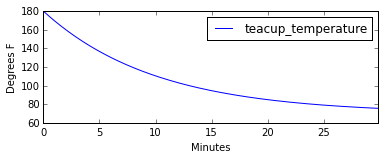

In [3]:
plt.figure(figsize(6,2))
stocks.plot()
plt.ylabel('Degrees F')
plt.xlabel('Minutes');

### Return additional model components

If we wish to see the values of model components other than the stocks, we can pass a list of component names with the keyword argument `return_columns`. This will change the columns of the returned dataframe such that they contain samples of the requested model components: 

,room_temperature,teacup_temperature
0.000,70,180.000000
0.125,70,178.633556
0.250,70,177.284092
0.375,70,175.951388
0.500,70,174.635239


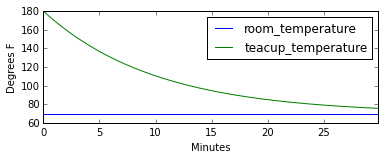

In [4]:
values = model.run(return_columns=['teacup_temperature', 'room_temperature'])
values.plot()
plt.ylabel('Degrees F')
plt.xlabel('Minutes')
values.head()

### Return values at a specific time

Sometimes we want to specify the timestamps that the run function should return values. For instance, if we are comparing the result of our model with data that arrives at irregular time intervals. We can do so using the `return_timestamps` keyword argument. This argument expects a list of timestamps, and will return values at those timestamps.

,teacup_temperature
0.0,180.000000
1.0,169.532119
3.0,151.490002
7.0,124.624385
9.5,112.541515


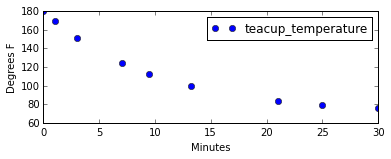

In [5]:
stocks = model.run(return_timestamps=[0,1,3,7,9.5, 13.178, 21, 25, 30])
stocks.plot(linewidth=0, marker='o')
plt.ylabel('Degrees F')
plt.xlabel('Minutes')
stocks.head()

### Modify parameter values
We can specify changes to the parameters of the model in the call to the run function. Here we set the room temperature to the constant value of 20 degrees before running the simulation.

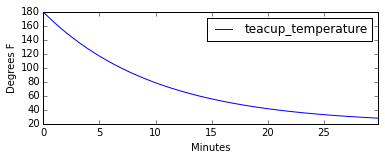

In [6]:
values = model.run(params={'room_temperature':20})
values.plot()
plt.ylabel('Degrees F')
plt.xlabel('Minutes');

We can also specify that a parameter be set with a time-varying input. In this case, we raise the room temperature from 20 to 80 degrees over the course of the 30 minutes. We can see that once the room temperature rises above that of the tea, the tea begins to warm up again.

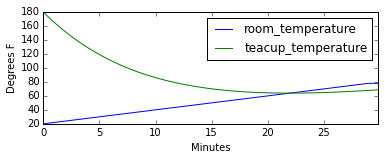

In [7]:
import pandas as pd
temp_timeseries = pd.Series(index=range(30), data=range(20,80,2))
values = model.run(params={'room_temperature':temp_timeseries},return_columns=['teacup_temperature', 'room_temperature'])
values.plot()
plt.ylabel('Degrees F')
plt.xlabel('Minutes');

### Specifying model initial conditions

In addition to parameters, we can set the initial conditions for the model, by passing a tuple to the argument `initial_condition`. In this case, the first element of the tuple is the time at which the model should begin its execution, and the second element of the tuple is a dictionary containing the values of the stocks at that particular time. 

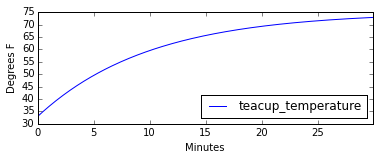

In [8]:
stocks = model.run(params={'room_temperature':75},
                   initial_condition=(0, {'teacup_temperature':33}))
stocks.plot()
plt.ylabel('Degrees F')
plt.xlabel('Minutes');

Once a model has been run, we can choose to run it forwards again from its current state. To do this we specify a new set of timestamps over which we would like the model to run, and pass the `intitial_condition` argument the string `"current"`.

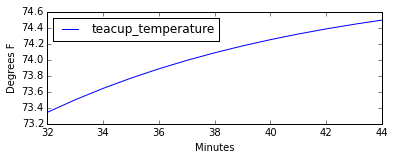

In [9]:
values = model.run(initial_condition='current', return_timestamps=range(31,45))
values.plot()
plt.ylabel('Degrees F')
plt.xlabel('Minutes');

### Collecting Results
To collect all output from a series of run commands into a record, set the `collect` flag to `True`.  We can then access an aggregation of all runs via the `.get_record()` method.

This can be helpful when running the model forwards for a period of time, then returning control to the user, who will specify changes to the model, and continue the integration forwards. In this case, we change the room temperature at 30 minutes, perhaps by taking the tea out into the cold.

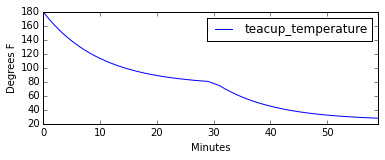

In [10]:
stocks0 = model.run(params={'room_temperature':75},
                    return_timestamps=range(0,30), collect=True)
stocks1 = model.run(params={'room_temperature':25}, initial_condition='current',
                    return_timestamps=range(30,60), collect=True)
stocks = model.get_record()

stocks.plot()
plt.ylabel('Degrees F')
plt.xlabel('Minutes');

To reset the record, use the method `.clear_record()` :

In [11]:
model.clear_record()